### Importing libraries

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

In [86]:
# Set parameters for better visualization
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 10)

### Reading the cleaned Data

In [87]:
df = pd.read_excel("MonthWiseMarketArrivals_ChennaiClean.xlsx")
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,date
0,CHENNAI,January,2004,103400,798,1019,910,2004-01-01
1,CHENNAI,February,2004,87800,776,969,873,2004-02-01
2,CHENNAI,March,2004,102180,506,656,580,2004-03-01
3,CHENNAI,April,2004,83300,448,599,527,2004-04-01
4,CHENNAI,May,2004,84850,462,596,529,2004-05-01


In [88]:
# change the date column to time interval column
df.date = pd.DatetimeIndex(df.date)

In [89]:
# change the index to date column
df = df.sort_values(by="date")
df.index = pd.PeriodIndex(df.date, freq="M")
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,date
date,,,,,,,,
2004-01,CHENNAI,January,2004,103400,798,1019,910,2004-01-01
2004-02,CHENNAI,February,2004,87800,776,969,873,2004-02-01
2004-03,CHENNAI,March,2004,102180,506,656,580,2004-03-01
2004-04,CHENNAI,April,2004,83300,448,599,527,2004-04-01
2004-05,CHENNAI,May,2004,84850,462,596,529,2004-05-01


### Neglecting unimportant variables

In [90]:
df = df.drop(["market","month","year","priceMin","priceMax"], axis=1)
df.tail()

,quantity,priceMod,date
date,,,
2021-01,35000,2976,2021-01-01
2021-02,33880,4211,2021-02-01
2021-03,26700,3300,2021-03-01
2021-04,15000,1100,2021-04-01
2021-05,13000,1150,2021-05-01


### Date vs Price

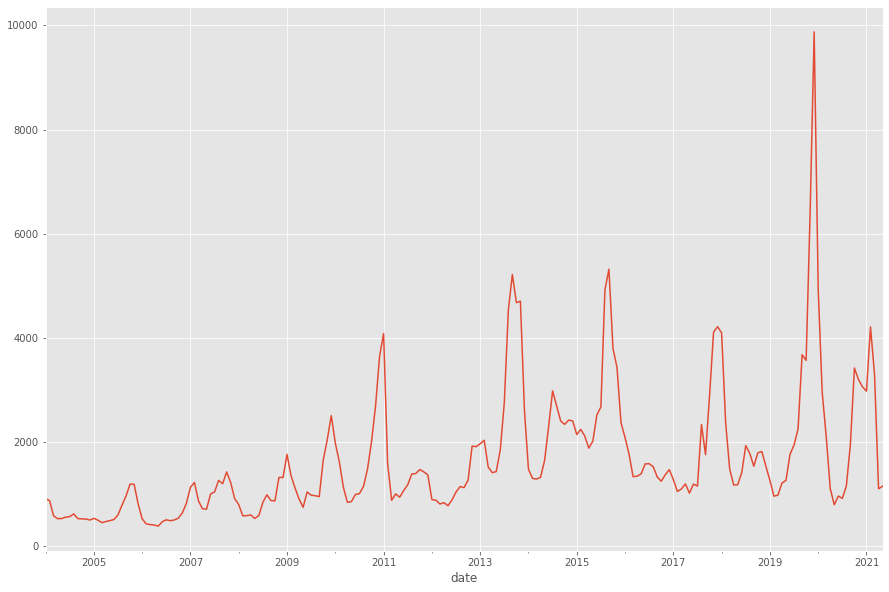

In [91]:
df.priceMod.plot()
plt.show()

### Date vs Quantity

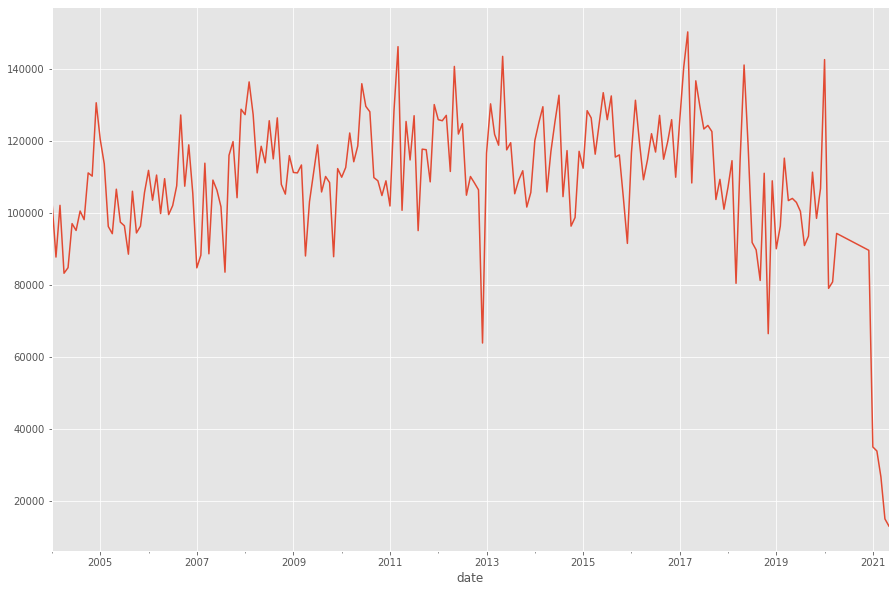

In [92]:
df.quantity.plot()
plt.show()

### Price distribution

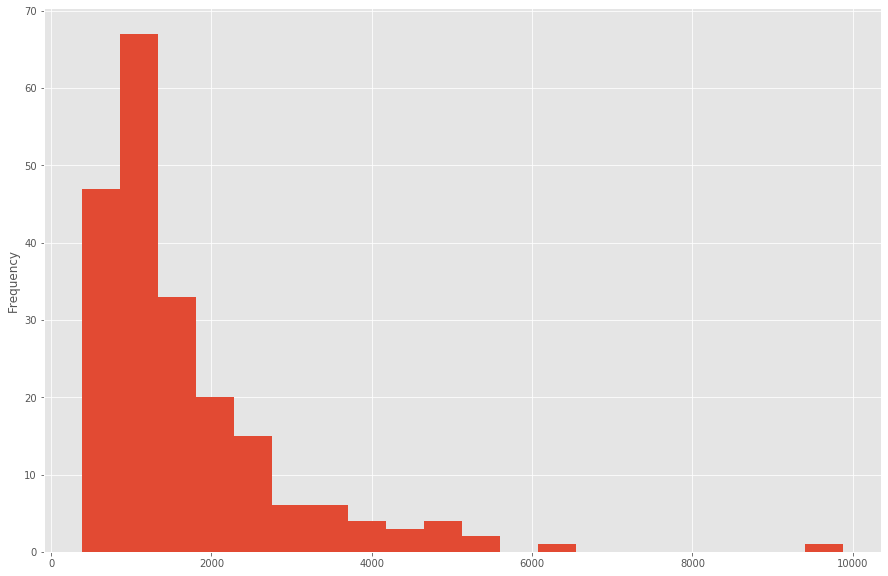

In [93]:
df.priceMod.plot(kind="hist", bins=20)

### Logged Price

Log-transformations can help to stabilize the variance of a time series. Let see using an example:

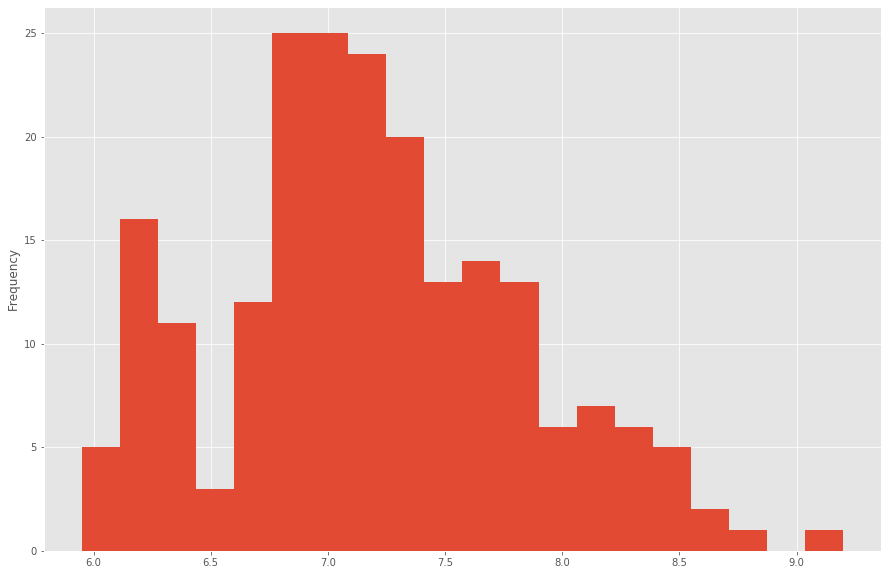

In [94]:
df["log_priceMod"] = np.log(df.priceMod)
df.log_priceMod.plot(kind="hist", bins=20)

The above histogram is more look like normal distribution

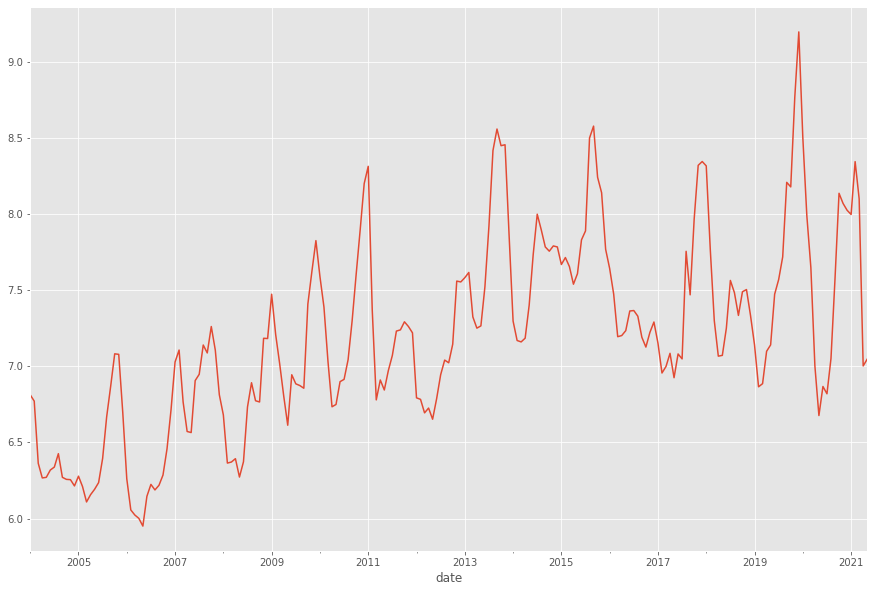

In [95]:
df.log_priceMod.plot()

### Basic Time Series Model

We will build a time-series forecasting model to get a forecast for Onion prices. Let us start with the three most basic models -

1. Mean Constant Model
2. Linear Trend Model
3. Random Walk Model

### 1. Mean Constant Model

In [96]:
df_mean = df.log_priceMod.mean()
df["mean_price"] = np.exp(df_mean)
df.head()

,quantity,priceMod,date,log_priceMod,mean_price
date,,,,,
2004-01,103400,910,2004-01-01,6.813445,1329.350118
2004-02,87800,873,2004-02-01,6.771936,1329.350118
2004-03,102180,580,2004-03-01,6.363028,1329.350118
2004-04,83300,527,2004-04-01,6.267201,1329.350118
2004-05,84850,529,2004-05-01,6.270988,1329.350118


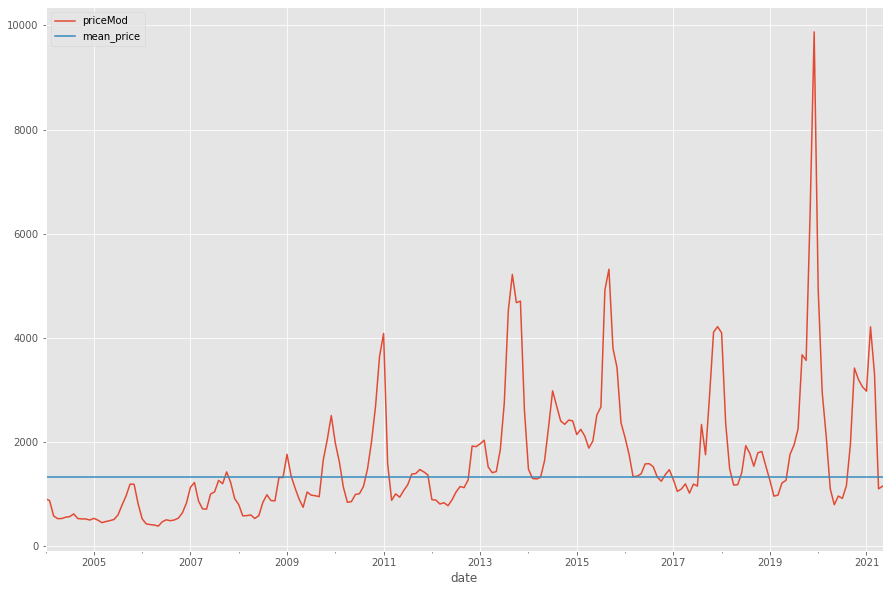

In [97]:
df.plot(kind="line", x="date", y=["priceMod", "mean_price"])

### Evaluate this model using RSME

In [98]:
def RMSE(actual, predicted):
    mse = (actual - predicted)**2
    rmse = np.sqrt(mse.sum()/mse.count())
    return rmse

In [99]:
mean_modelRMSE = RMSE(df.priceMod, df.mean_price)
mean_modelRMSE

1280.8452519567788

In [100]:
Result_df = pd.DataFrame(columns =["Model","Actual","Forcast","RMSE"])
Result_df.loc[0,"Model"] = "Mean Model"
Result_df.loc[0,"Actual"] = "1150"
Result_df.loc[0,"Forcast"] = np.exp(df_mean)
Result_df.loc[0,"RMSE"] = mean_modelRMSE
Result_df

,Model,Actual,Forcast,RMSE
0,Mean Model,1150,1329.35,1280.85


### 2. Linear Trend Model

Let us start by plotting a linear trend model between log_priceMod and time.

However to do linear regression, we need a numeric indicator for time period - Let us create that

In [101]:
df.head()

,quantity,priceMod,date,log_priceMod,mean_price
date,,,,,
2004-01,103400,910,2004-01-01,6.813445,1329.350118
2004-02,87800,873,2004-02-01,6.771936,1329.350118
2004-03,102180,580,2004-03-01,6.363028,1329.350118
2004-04,83300,527,2004-04-01,6.267201,1329.350118
2004-05,84850,529,2004-05-01,6.270988,1329.350118


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 209 entries, 2004-01 to 2021-05
Freq: M
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   quantity      209 non-null    int64         
 1   priceMod      209 non-null    int64         
 2   date          209 non-null    datetime64[ns]
 3   log_priceMod  209 non-null    float64       
 4   mean_price    209 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 9.8 KB


In [103]:
# Converting the date into datetinme delta starting from 0
df["timeindex"] = df.date - df.date.min()
df.head()

,quantity,priceMod,date,log_priceMod,mean_price,timeindex
date,,,,,,
2004-01,103400,910,2004-01-01,6.813445,1329.350118,0 days
2004-02,87800,873,2004-02-01,6.771936,1329.350118,31 days
2004-03,102180,580,2004-03-01,6.363028,1329.350118,60 days
2004-04,83300,527,2004-04-01,6.267201,1329.350118,91 days
2004-05,84850,529,2004-05-01,6.270988,1329.350118,121 days


In [104]:
df.dtypes

quantity                  int64
priceMod                  int64
date             datetime64[ns]
log_priceMod            float64
mean_price              float64
timeindex       timedelta64[ns]
dtype: object

In [105]:
# converting the timeindex into months using timedelta
df["timeindex"] = df["timeindex"]/np.timedelta64(1,"M")
df.head()

,quantity,priceMod,date,log_priceMod,mean_price,timeindex
date,,,,,,
2004-01,103400,910,2004-01-01,6.813445,1329.350118,0.000000
2004-02,87800,873,2004-02-01,6.771936,1329.350118,1.018501
2004-03,102180,580,2004-03-01,6.363028,1329.350118,1.971293
2004-04,83300,527,2004-04-01,6.267201,1329.350118,2.989794
2004-05,84850,529,2004-05-01,6.270988,1329.350118,3.975441


In [106]:
df["timeindex"] = df["timeindex"].round(0).astype(int)
df.tail()

,quantity,priceMod,date,log_priceMod,mean_price,timeindex
date,,,,,,
2021-01,35000,2976,2021-01-01,7.998335,1329.350118,204
2021-02,33880,4211,2021-02-01,8.345455,1329.350118,205
2021-03,26700,3300,2021-03-01,8.101678,1329.350118,206
2021-04,15000,1100,2021-04-01,7.003065,1329.350118,207
2021-05,13000,1150,2021-05-01,7.047517,1329.350118,208


### Apply the linear model

In [107]:
linear_model = smf.ols('log_priceMod ~ timeindex', data = df).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_priceMod   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     155.6
Date:                Tue, 11 May 2021   Prob (F-statistic):           5.40e-27
Time:                        12:35:10   Log-Likelihood:                -142.29
No. Observations:                 209   AIC:                             288.6
Df Residuals:                     207   BIC:                             295.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.4782      0.066     97.844      0.000       6.348       6.609
timeindex      0.0069      0.001     12.472      0.000       0.006       0.008
==============================================================================
Omnibus:                        8.496   Durbin-Watson:                   0.295
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                8.439
Skew:                           0.482   Prob(JB):                       0.0147
Kurtosis:                       3.196   Cond. No.                         240.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [108]:
linear_model_pred = linear_model.predict()
linear_model_pred

array([6.47817295, 6.48504095, 6.49190896, 6.49877696, 6.50564497,
       6.51251297, 6.51938098, 6.52624898, 6.53311699, 6.53998499,
       6.546853  , 6.553721  , 6.56058901, 6.56745701, 6.57432502,
       6.58119302, 6.58806103, 6.59492903, 6.60179704, 6.60866504,
       6.61553305, 6.62240105, 6.62926906, 6.63613706, 6.64300507,
       6.64987307, 6.65674108, 6.66360908, 6.67047709, 6.67734509,
       6.6842131 , 6.6910811 , 6.69794911, 6.70481711, 6.71168512,
       6.71855312, 6.72542113, 6.73228913, 6.73915714, 6.74602514,
       6.75289315, 6.75976115, 6.76662916, 6.77349716, 6.78036517,
       6.78723317, 6.79410118, 6.80096918, 6.80783719, 6.81470519,
       6.8215732 , 6.8284412 , 6.83530921, 6.84217721, 6.84904522,
       6.85591322, 6.86278123, 6.86964923, 6.87651724, 6.88338524,
       6.89025325, 6.89712125, 6.90398926, 6.91085726, 6.91772527,
       6.92459327, 6.93146128, 6.93832928, 6.94519729, 6.95206529,
       6.9589333 , 6.9658013 , 6.97266931, 6.97953731, 6.98640

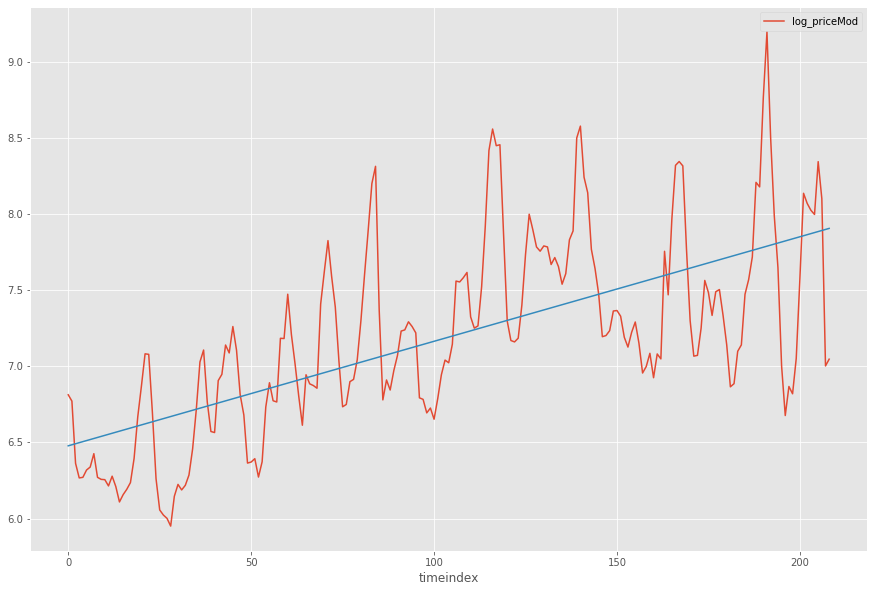

In [109]:
df.plot(kind = "line", x="timeindex", y="log_priceMod")
plt.plot(df.timeindex, linear_model_pred)

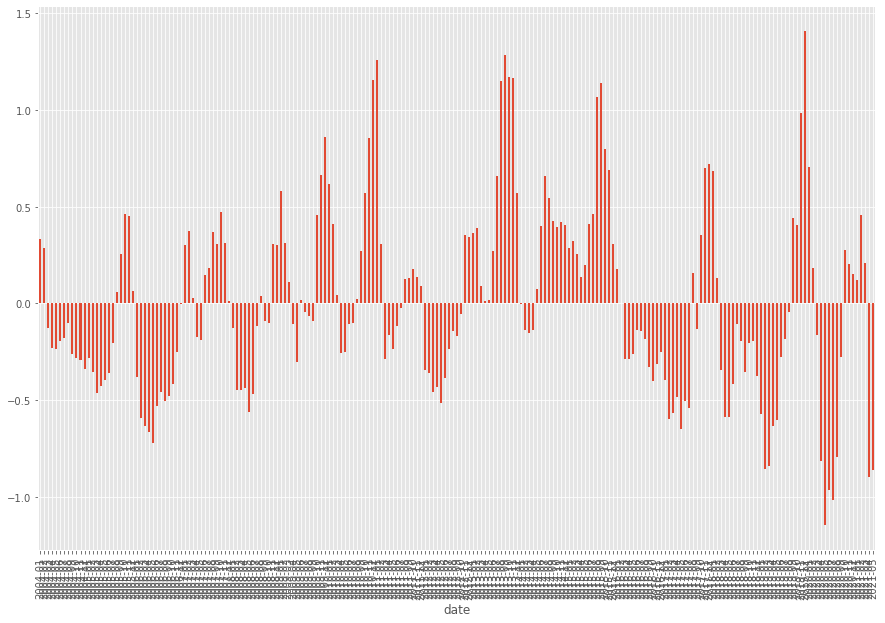

In [110]:
linear_model.resid.plot(kind="bar")

What measures can we check to see if the model is good?

It is seen here (and also evident on the regression line plot, if you look closely) that the linear trend model has a tendency to make an error of the same sign for many periods in a row. This tendency is measured in statistical terms by the lag-1 autocorrelation and Durbin-Watson statistic. If there is no time pattern, the lag-1 autocorrelation should be very close to zero, and the Durbin-Watson statistic ought to be very close to 2, which is not the case here. If the model has succeeded in extracting all the "signal" from the data, there should be no pattern at all in the errors: the error in the next period should not be correlated with any previous errors. The linear trend model obviously fails the autocorrelation test in this case.

1. Durbin Watson statistic is a test for autocorrelation in a data set.
2. The DW statistic always has a value between zero and 4.0.
3. A value of 2.0 means there is no autocorrelation detected in the sample. Values from zero to 2.0 indicate positive autocorrelation and values from 2.0 to 4.0 indicate negative autocorrelation

A stock price displaying positive autocorrelation would indicate that the price yesterday has a positive correlation on the price today—so if the stock fell yesterday, it is also likely that it falls today. A security that has a negative autocorrelation, on the other hand, has a negative influence on itself over time—so that if it fell yesterday, there is a greater likelihood it will rise today.

In [111]:
# Manual Calculation
model_linear_forecast_manual = 0.0077 * 155 + 6.4679
model_linear_forecast_manual

7.6614

In [112]:
df["linear_price"] = np.exp(linear_model_pred)
df.head()

,quantity,priceMod,date,log_priceMod,mean_price,timeindex,linear_price
date,,,,,,,
2004-01,103400,910,2004-01-01,6.813445,1329.350118,0,650.780849
2004-02,87800,873,2004-02-01,6.771936,1329.350118,1,655.265799
2004-03,102180,580,2004-03-01,6.363028,1329.350118,2,659.781657
2004-04,83300,527,2004-04-01,6.267201,1329.350118,3,664.328638
2004-05,84850,529,2004-05-01,6.270988,1329.350118,4,668.906954


In [113]:
linear_model_RMSE = RMSE(df.priceMod, df.linear_price)
linear_model_RMSE

1102.7235318458418

In [114]:
Result_df.loc[1,"Model"] = "Linear Model"
Result_df.loc[1,"Actual"] = "1150"
Result_df.loc[1,"Forcast"] = np.exp(model_linear_forecast_manual)
Result_df.loc[1,"RMSE"] = linear_model_RMSE
Result_df

,Model,Actual,Forcast,RMSE
0,Mean Model,1150,1329.35,1280.85
1,Linear Model,1150,2124.73,1102.72


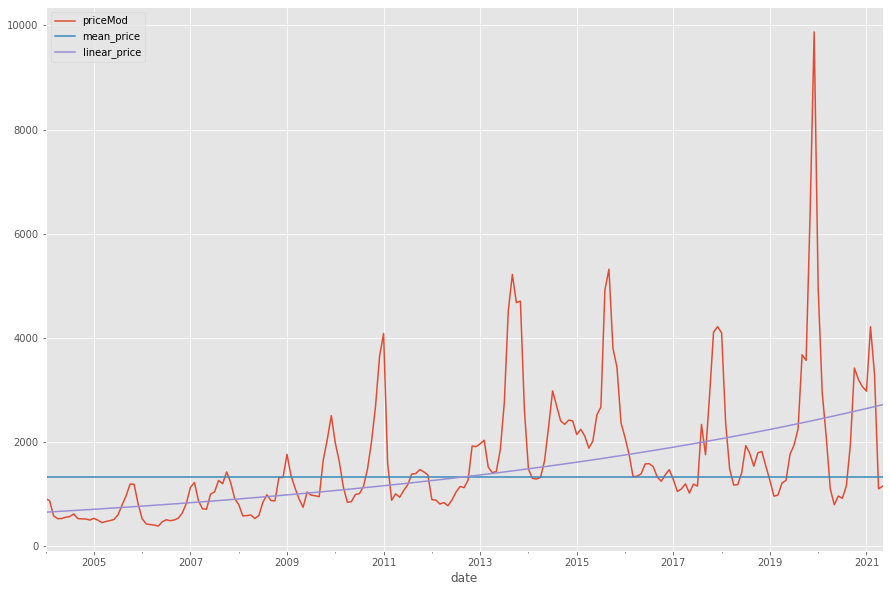

In [115]:
df.plot(kind="line", x="date", y=["priceMod", "mean_price","linear_price"])

In [116]:
linear_model_quant = smf.ols('log_priceMod ~ timeindex + np.log(quantity)', data = df).fit()
linear_model_quant.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_priceMod   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     78.66
Date:                Tue, 11 May 2021   Prob (F-statistic):           4.17e-26
Time:                        12:35:18   Log-Likelihood:                -141.56
No. Observations:                 209   AIC:                             289.1
Df Residuals:                     206   BIC:                             299.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.8049      1.399      3.435      0.001       2.047       7.563
timeindex            0.0070      0.001     12.437      0.000       0.006       0.008
np.log(quantity)     0.1433      0.120      1.197      0.232      -0.093       0.379
==============================================================================
Omnibus:                        8.642   Durbin-Watson:                   0.302
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                8.696
Skew:                           0.495   Prob(JB):                       0.0129
Kurtosis:                       3.131   Cond. No.                     5.10e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

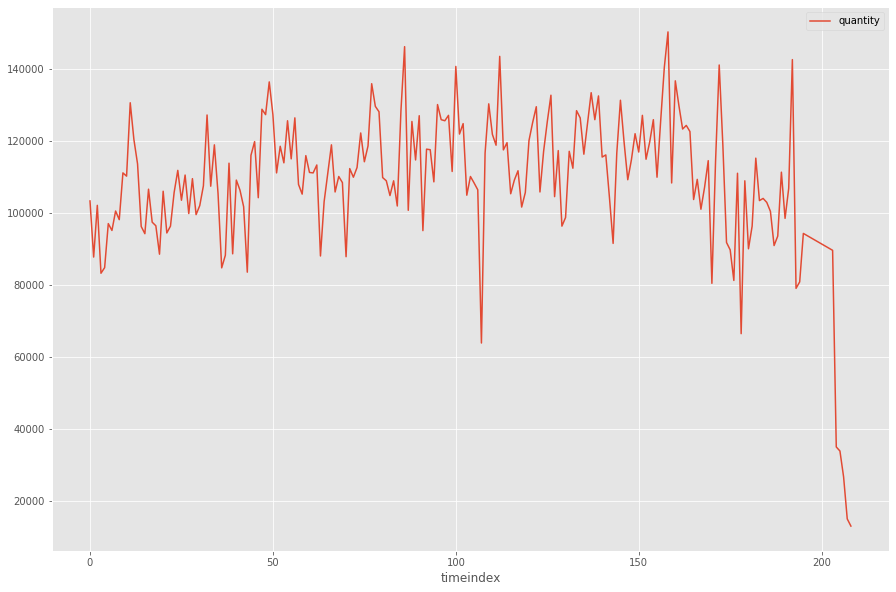

In [117]:
df["linear_price_quant"] = np.exp(linear_model_quant.predict())
df.plot(kind = "line", x="timeindex", y = "quantity")
plt.show()

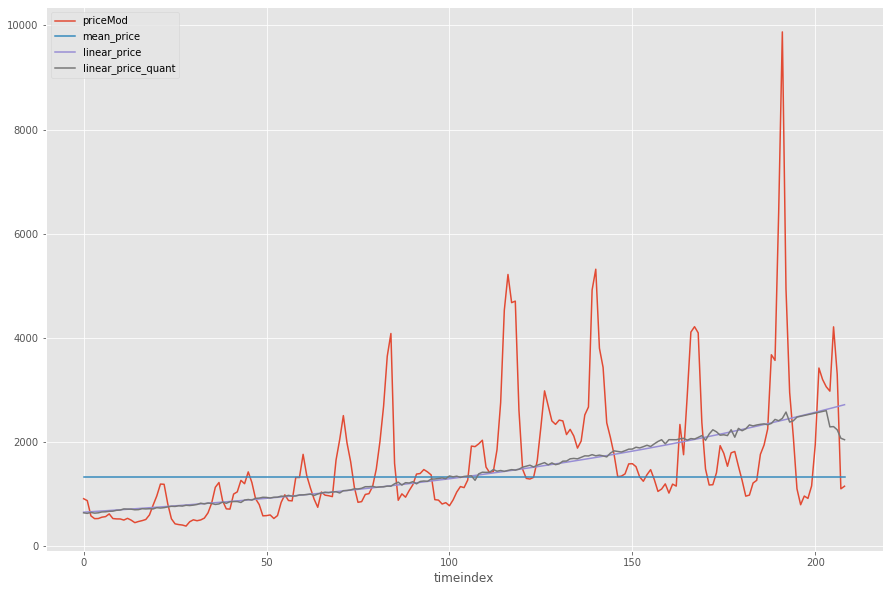

In [118]:
df.plot(kind="line", x="timeindex", y = ["priceMod", "mean_price", 
                                             "linear_price", "linear_price_quant"])
plt.show()

### 3. Random Walk Model

When faced with a time series that shows irregular growth, the best strategy may not be to try to directly predict the level of the series at each period (i.e., the quantity Yt). Instead, it may be better to try to predict the change that occurs from one period to the next (i.e., the quantity Yt - Yt-1).

That is, it may be better to look at the first difference of the series, to see if a predictable pattern can be found there. For purposes of one-period-ahead forecasting, it is just as good to predict the next change as to predict the next level of the series, since the predicted change can be added to the current level to yield a predicted level. The simplest case of such a model is one that always predicts that the next change will be zero, as if the series is equally likely to go up or down in the next period regardless of what it has done in the past.

There are two types of random walks

1. Random walk without drift (no constant or intercept)
2. Random walk with drift (with a constant term)


In [119]:
df["shift_log_priceMod"] = df.log_priceMod.shift()
df.head()

,quantity,priceMod,date,log_priceMod,mean_price,timeindex,linear_price,linear_price_quant,shift_log_priceMod
date,,,,,,,,,
2004-01,103400,910,2004-01-01,6.813445,1329.350118,0,650.780849,638.744335,NaN
2004-02,87800,873,2004-02-01,6.771936,1329.350118,1,655.265799,628.343794,6.813445
2004-03,102180,580,2004-03-01,6.363028,1329.350118,2,659.781657,646.673371,6.771936
2004-04,83300,527,2004-04-01,6.267201,1329.350118,3,664.328638,632.440354,6.363028
2004-05,84850,529,2004-05-01,6.270988,1329.350118,4,668.906954,638.579895,6.267201


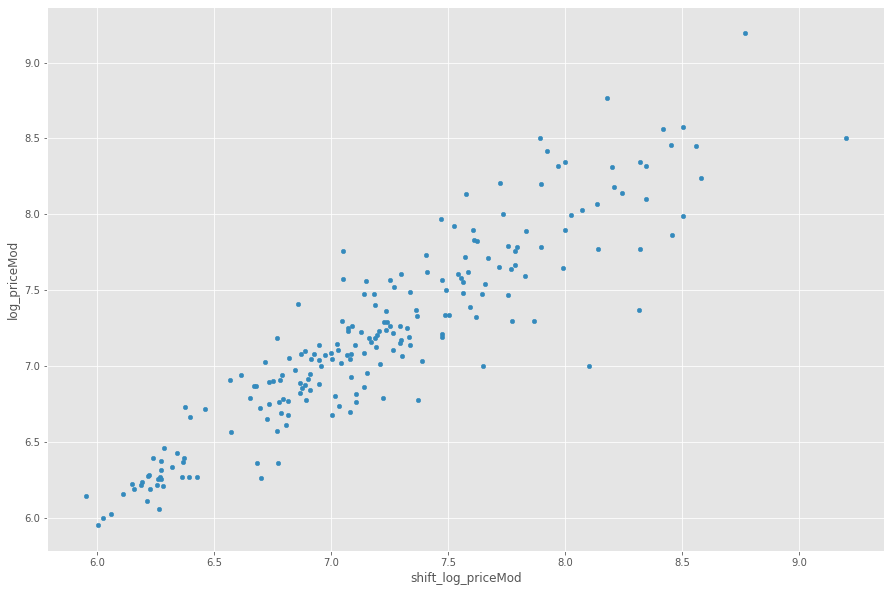

In [120]:
df.plot(kind="scatter", x="shift_log_priceMod", y ="log_priceMod", s=20 )

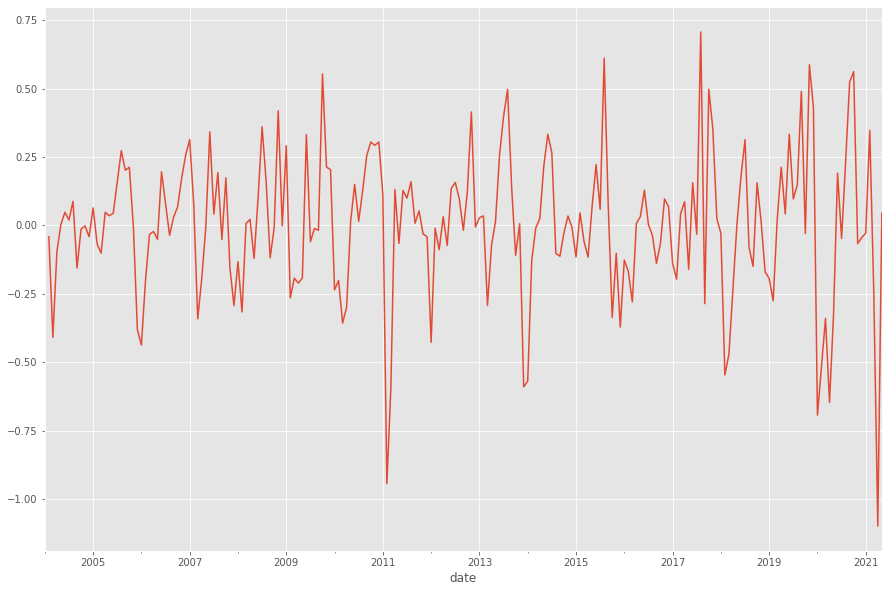

In [121]:
df["log_priceMod_diff"] = df.log_priceMod - df.shift_log_priceMod
df.log_priceMod_diff.plot()

In [122]:
df["random_price"] = np.exp(df.shift_log_priceMod)
df.head()

,quantity,priceMod,date,log_priceMod,mean_price,timeindex,linear_price,linear_price_quant,shift_log_priceMod,log_priceMod_diff,random_price
date,,,,,,,,,,,
2004-01,103400,910,2004-01-01,6.813445,1329.350118,0,650.780849,638.744335,NaN,NaN,NaN
2004-02,87800,873,2004-02-01,6.771936,1329.350118,1,655.265799,628.343794,6.813445,-0.041509,910.0
2004-03,102180,580,2004-03-01,6.363028,1329.350118,2,659.781657,646.673371,6.771936,-0.408907,873.0
2004-04,83300,527,2004-04-01,6.267201,1329.350118,3,664.328638,632.440354,6.363028,-0.095828,580.0
2004-05,84850,529,2004-05-01,6.270988,1329.350118,4,668.906954,638.579895,6.267201,0.003788,527.0


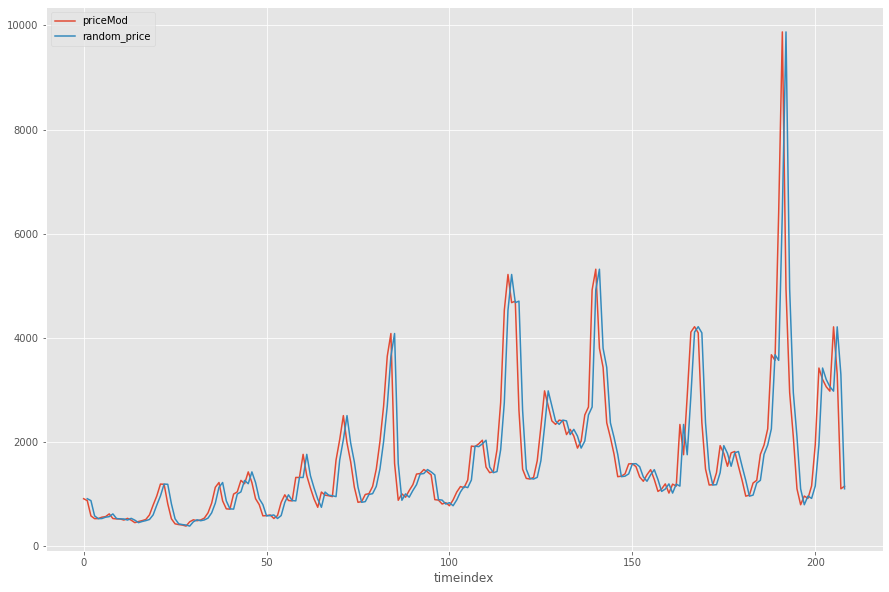

In [123]:
# lets compare random price and actual price
df.plot(kind="line", x="timeindex", y = ["priceMod", "random_price"])

In [124]:
# evaluate the random walk model
random_model_RMSE = RMSE(df.priceMod, df.random_price)
random_model_RMSE

717.7266594549124

In [125]:
Result_df.loc[2,"Model"] = "Random Model"
Result_df.loc[2,"Actual"] = "1150"
Result_df.loc[2,"Forcast"] = np.exp(df.shift_log_priceMod[-1])
Result_df.loc[2,"RMSE"] = random_model_RMSE
Result_df

,Model,Actual,Forcast,RMSE
0,Mean Model,1150,1329.35,1280.85
1,Linear Model,1150,2124.73,1102.72
2,Random Model,1150,1100,717.727


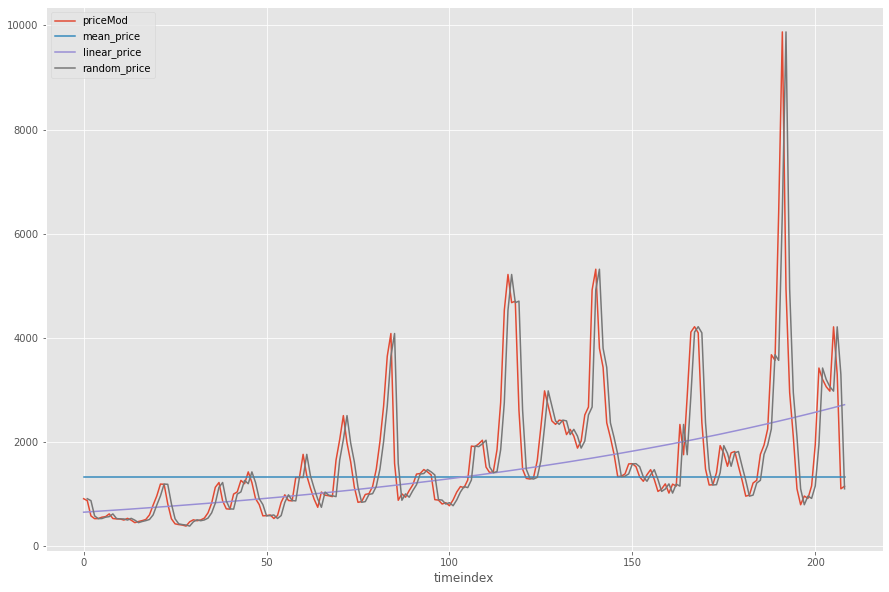

In [126]:
df.plot(kind="line", x="timeindex", y = ["priceMod", "mean_price", "linear_price", "random_price"])